## Grid Generators

We will need lots of complete grids to train the GNN. Here are a few methods for making them as fast as possible

In [1]:
from timeit import timeit
from random import shuffle

from abc import ABC

import numpy as np
from numpy.lib.stride_tricks import as_strided

import matplotlib.pyplot as plt

In [53]:
class GridGenerator(ABC):
    """
    The Grid generators will take in a grid shape and a tuple,
    and have a method `generate_n_grids`

    Grids have -1 for mines, and a count for every other cell
    """
    def __init__(self, grid_shape: tuple[int, int] = (16, 16),
                 num_mines: int = 44):
        self.grid_shape = grid_shape
        self.rows, self.columns = grid_shape
        self.size = self.rows * self.columns
        self.num_mines = num_mines

    def generate_n_grids(self, N: int) -> np.ndarray:
        raise NotImplementedError

In [54]:

class GridGenerator1(GridGenerator):
    """
    Generate lad-sweeper grids

    Method
    ------
    1. Generate a list of coordinates for every cell in the 2D
       array.
    2. Shuffle the list in place
    3. Take the first `num_mines` coordinates and enter mines
       into those cells
    4. Place the mined grid into a padded array with a strided
       view of all the neighbours
    5. Sum the padded view over the last 2 indices, take the
       absolute value
    6. Put the mines back into place and return the grid
    """
    def __init__(self,
                 grid_shape: tuple[int, int] = (16, 16),
                 num_mines: int = 44):
        """
        Parameters
        ----------
        grid_shape: tuple[int, int]
            The number of rows and columns which will make up the grid
        num_mines: int
            The number of mines the grid should contain
        """
        super().__init__(grid_shape, num_mines)

        # Set up a padded grid which allows a strided view of every
        # cell's neighbours
        padded_shape = (self.rows + 2, self.columns + 2)
        neighbours_shape = (self.rows, self.columns, 3, 3)

        self.padded_grid = np.zeros(padded_shape, dtype=np.int8)
        self.neighbours = as_strided(self.padded_grid,
                                     shape=neighbours_shape,
                                     strides=self.padded_grid.strides * 2)

        # Store a list of coords shape (self.size, 2)
        self.coords = np.indices(grid_shape).reshape(2, -1).T

    def __iter__(self):
        return self

    def __next__(self):
        return self.make_grid()

    def make_grid(self) -> np.ndarray:
        """
        Make a grid with the specified shape

        Returns
        -------
        grid: np.ndarray
            A filled grid
        """
        np.random.shuffle(self.coords) #  in place
        board = np.zeros(self.grid_shape, dtype=np.int8)
        board[tuple(self.coords[:self.num_mines].T)] = -1

        self.padded_grid[1:-1, 1:-1] = board
        counts = np.abs(np.sum(self.neighbours, axis=(3, 2)))
        counts[tuple(self.coords[:self.num_mines].T)] = -1 # reset the mines
        return counts

    def generate_n_grids(self, N: int) -> np.ndarray:
        """
        Return N complete lad-sweeper grids

        Parameters
        ----------
        N: int
            Number of grids to make

        Returns
        -------
        grids: np.ndarray
            A numpy array of grids with shape (N, *self.size)
        """
        return np.array([next(self) for _ in range(N)])


In [55]:
class GridGenerator2(GridGenerator):
    """
    A method to generate lad-sweeper grids

    Method
    ------
    1. Generate N sets of shuffled coordinates 1D coordinates.
       Return the first `num_mines` from each set of coordinates
    2. Insert the N coordinates into a 3D pre-made stack of grids
       with a NumPy strided view into it of all the neighbours.
    3. Take the absolute value of the sum of all the neighbours
    4. Put the mines back in place
    """
    def __init__(self, grid_shape=(16,16), num_mines=44):
        super().__init__(grid_shape, num_mines)

        self.rng = np.random.default_rng()

    def generate_n_grids(self, N: int) -> np.ndarray:
        """
        Generate N lad-sweeper grids

        Parameters
        ----------
        N: int
            The number of grids to make

        Returns
        -------
        grids: np.ndarray
            An array with shape (N, *self,shape)
        """
        # Make a 3D grid padded in the last 2 dimensions to store
        # the mine values
        padded_shape = (N, self.rows + 2, self.columns+2)
        padded = np.zeros(padded_shape, dtype=np.int8)

        # Make N grids with -1 for mines, 0 elsewhere
        mined_grids = self.generate_n_mined_boards(N)
        # Insert them into padded
        padded[:,1:-1,1:-1] = mined_grids

        # Create a strided view of the neighbours of each layer
        strides = (padded.strides[0],) + padded.strides[1:]*2
        new_shape = (N, self.rows, self.columns, 3, 3)
        neighbours = as_strided(padded, new_shape, strides)

        # Sum all of the neighbours over the last 2 axes
        counts = np.abs(np.sum(neighbours, axis=(-1, -2)))

        # Return summed value or mine
        return np.where(mined_grids == -1, -1, counts)

    def generate_n_coords(self, N: int) -> np.ndarray:
        """
        Return N rows of 1D coordinates containing mines

        Parameters
        ----------
        N: int
            Number of rows of mines to generate
        
        Returns
        -------
        mine_coords: np.ndarray
            2D array of 1D mine coordinates with shape
            (N, self.num_mines)
        """
        return np.vstack([self.rng.permutation(self.size)
                          for _ in range(N)])[:,:self.num_mines]

    def generate_n_mined_boards(self, N: int) -> np.array:
        """
        Return N 2D lad-sweeper boards with mines in place
        but no counts

        Parameters
        ----------
        N: int
            Number of mined boards to make

        Returns
        -------
        mined_grids: np.ndarray
            Grids with mines in place but no counts
        """
        boards = np.zeros((N, self.size), dtype=np.int8)
        rows = np.repeat(np.arange(N), self.num_mines)
        mines = self.generate_n_coords(N)
        boards[(rows.flatten(), mines.flatten())] = -1
        return boards.reshape(N, *self.grid_shape)

In [56]:
class GridGenerator3(GridGenerator2):
    """
    The same as GridGenerator2 except we will use a different
    method to generate the mine coordinates
    """
    def __init__(self, grid_shape=(16,16), num_mines=44):
        super().__init__(grid_shape, num_mines)

    def generate_n_coords(self, N: int) -> np.ndarray:
        """
        Use the built in NumPy shuffle with axis 1
        """
        coords = np.arange(self.size, dtype=np.int8) * np.ones(N, dtype=np.int8)[:,None]
        return self.rng.permuted(coords, axis=1)[:, :self.num_mines]

In [57]:
class GridGenerator4(GridGenerator):
    """
    Last method to generate lad-sweeper grids

    Method
    ------
    1. Make an array of all the neighbours of a flattened lad-sweeper
       grid. Shape (self.size, 8). If the neighbour doesn't exist -1
    2. Make an array of mine locations in a 1D array
    3. Make an array of zeros self.size * self.N and insert the mines
    4. Fancy index the extended neighbours into the mine array
    5. Replace the mines
    """
    def __init__(self, grid_shape=(16, 16), num_mines=44):
        super().__init__(grid_shape, num_mines)

        self.rng = np.random.default_rng()
        self.neibs = self.get_1d_neighbours()

    def get_1d_neighbours(self) -> np.ndarray:
        """
        Return an array of neighbours with shape (self.size, 8)

        If a value doesn't have a neighbour set it to -1
        """
        padded_shape = (self.rows + 2, self.columns + 2)
        padded = np.full(padded_shape, -1, dtype=np.int8)
        padded[1:-1, 1:-1] = np.arange(self.size).reshape(self.grid_shape)
        neibs = as_strided(padded, (*self.grid_shape, 3, 3), padded.strides*2)
        neibs = neibs.reshape(-1, 9)
        return np.c_[neibs[:,:4], neibs[:,5:]]
    
    def generate_n_coords(self, N: int) -> np.array:
        """
        Return a 1D numpy array of  random mine coordinates
        Shape (self.num_mines * N, )

        Every num_mines self.size is added to the coordinates
        """
        coords = np.arange(self.size) * np.ones(N, dtype=np.int64)[:,None]
        coords = self.rng.permuted(coords, axis=1)[:, :self.num_mines]
        coords += (np.arange(N) * self.size)[:, None]
        return coords.flatten()

    def generate_n_mined_boards(self, N: int) -> np.ndarray:
        """
        Generate N lots of coords and put them into a flattened
        array of 0s
        """
        boards = np.zeros((N * self.size), dtype=np.int8)
        boards[self.generate_n_coords(N)] = -1
        return boards

    def generate_n_grids(self, N):
        boards = self.generate_n_mined_boards(N)
        boards_extra = np.append(boards, 0) #  0 on the end for -1 coords to point at
        
        extended_neibs = (np.tile(self.neibs, (N, 1)) +
                          (np.repeat(np.arange(N), self.size) * self.size)[:,None])
        extended_neibs = np.where(np.tile(self.neibs, (N, 1))==-1, -1, extended_neibs) # Put the non-existent neighbours back
        counts = np.abs(np.sum(boards_extra[extended_neibs], axis=1)) # Add up the mine counts
        return np.where(boards==-1, -1, counts).reshape(N, *self.grid_shape) # Put the mines back

In [58]:
class GridGenerator5:
    """
    A version using vanilla python
    """
    NEIBS = tuple((i, j) for i in (-1, 0, 1) for j in (-1, 0, 1) if not i==j==0)

    def __init__(self, grid_shape=(16, 16), num_mines=44):
        self.grid_shape = grid_shape
        self.rows, self.columns = grid_shape
        self.num_mines = num_mines

        self.coords = [(i, j) for i in range(self.rows) for j in range(self.columns)]

    def generate_mined_board(self) -> list[list[int]]:
        shuffle(self.coords)
        grid = [[0 for _ in range(self.columns)] for _ in range(self.rows)]
        for i, j in self.coords[:self.num_mines]:
            grid[i][j] = -1
        return grid

    def generate_grid(self):
        return self.count_mines(self.generate_mined_board())

    def generate_n_grids(self, N: int) -> list[list[list[int]]]:
        return [self.generate_grid() for _ in range(N)]
    
    def count_mines(self, board: list[list[int]]) -> list[list[int]]:
        for i in range(self.rows):
            for j in range(self.columns):
                if board[i][j] < 0:
                    continue
                total = 0
                for x, y in self.NEIBS:
                    if self.check_coord((i+y, j+x)) and board[i+y][j+x] < 0:
                        total += 1
                board[i][j] = total
        return board
    
    def check_coord(self, coord: tuple[int, int]) -> bool:
        """
        Return True if the coord is in the grid else false
        """
        i, j = coord
        if (0 <= i and
            0 <= j and
            self.rows > i and
            self.columns > j):
            return True
        return False


In [64]:
def timer(gen_no: int, N: int, repeats: int=3) -> float:
    setup = f"from __main__ import GridGenerator{gen_no}; gen=GridGenerator{gen_no}()"
    stmt = f"gen.generate_n_grids({N})"
    return timeit(stmt, setup, number=repeats) / repeats

In [59]:
Ns = (10**np.linspace(1, 5, 15)).astype(int)

times = [[timer(gen_no, N) for N in Ns]
         for gen_no in range(1, 5)]


In [65]:
# Default python
py_Ns = (10**np.linspace(1, 3.5, 15)).astype(int)
py_times = [timer(5, N) for N in Ns]

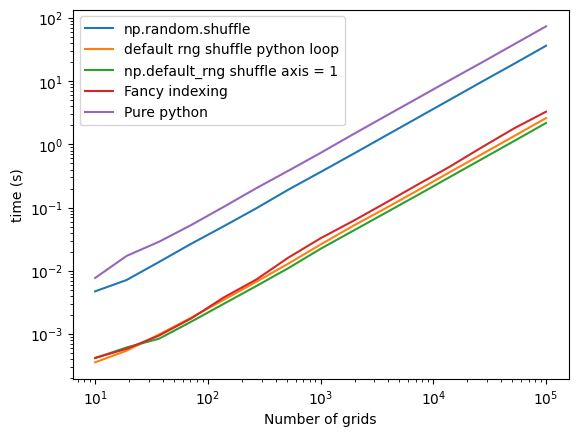

In [67]:
labels = (
    "np.random.shuffle",
    "default rng shuffle python loop",
    "np.default_rng shuffle axis = 1",
    "Fancy indexing"
)

for label, ts in zip(labels, times):
    plt.plot(Ns, ts, label=label)

plt.plot(Ns, py_times, label="Pure python")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of grids")
plt.ylabel("time (s)")
plt.legend()
plt.show()

## Methods of generating mine coordinates

About half the time taken to make a board is generating the coordinates for mines. here's how a few methods stack up against each other.

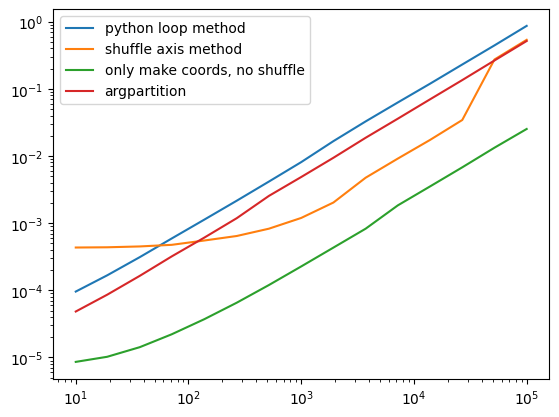

In [6]:
def generate_N_coords_1(N, rng):
    return np.vstack([rng.permutation(256) for _ in range(N)])

def generate_N_coords_2(N, rng):
    coords = np.arange(256, dtype=np.int8) * np.ones(N, dtype=np.int8)[:,None]
    rng.shuffle(coords, axis=1)
    return coords

def generate_N_coords_3(N, rng):
    coords = np.arange(256, dtype=np.int8) * np.ones(N, dtype=np.int8)[:,None]
    #rng.shuffle(coords, axis=1)
    return coords

def generate_N_coords_4(N, rng):
    rands = rng.random((N, 256))
    return np.argpartition(rands, 99, axis=1)[:, :99]

def timer(i, N):
    setup = f"from __main__ import generate_N_coords_{i}; import numpy as np; rng=np.random.default_rng()"
    stmt = f"generate_N_coords_{i}({N}, rng)"
    return timeit(stmt, setup, number=100) / 100

Ns = (10**np.linspace(1, 5, 15)).astype(int)

times_1 = [timer(1, N) for N in Ns]
times_2 = [timer(2, N) for N in Ns]
times_3 = [timer(3, N) for N in Ns]
times_4 = [timer(4, N) for N in Ns]

plt.plot(Ns, times_1, label="python loop method")
plt.plot(Ns, times_2, label="shuffle axis method")
plt.plot(Ns, times_3, label="only make coords, no shuffle")
plt.plot(Ns, times_4, label="argpartition")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.show()

In [ ]:
generate_N_coords_4(10, np.random.default_rng())